In [14]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
%matplotlib inline

In [15]:
# Initialising required parameters

# The list of random states
ran_state = [0, 10, 21, 42, 66, 109, 310, 1969]

# The list of alpha for regularization
alphas = [1e-7,1e-5, 1e-3, 0.01, 0.1, 1]

# The degree of the polynomial
degree= 30

In [16]:
# Read the file 'polynomial50.csv' as a dataframe
df = pd.read_csv('polynomial50.csv')

# Assign the values of the 'x' column as the predictor
x = df[['x']].values

# Assign the values of the 'y' column as the response
y = df['y'].values

# Also assign the true value of the function (column 'f') to the variable f 
f = df['f'].values

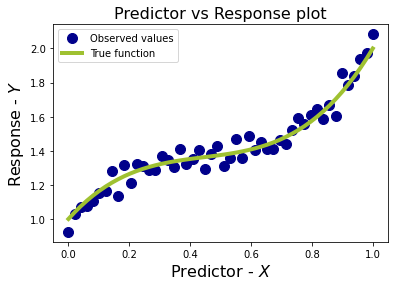

In [17]:
# Use the helper code below to visualise the distribution of the x, y values & also the value of the true function f

fig, ax = plt.subplots()

# Plot x vs y values
ax.plot(x,y, 'o', label = 'Observed values',markersize=10 ,color = 'Darkblue')

# Plot x vs true function value
ax.plot(x,f, 'k-', label = 'True function',linewidth=4,color ='#9FC131FF')

ax.legend(loc = 'best');
ax.set_xlabel('Predictor - $X$',fontsize=16)
ax.set_ylabel('Response - $Y$',fontsize=16)
ax.set_title('Predictor vs Response plot',fontsize=16);

In [18]:
# Function to perform regularization with simple validation
def reg_with_validation(rs):
    
    # Split the data into train and validation sets with train size as 80% and random_state as
    x_train, x_val, y_train, y_val = train_test_split(x,y, train_size = 0.8, random_state=rs)

    # Create two lists for training and validation error
    training_error, validation_error = [],[]

    # Compute the polynomial features train and validation sets
    x_poly_train = PolynomialFeatures(degree).fit_transform(x_train.reshape(-1,1))
    x_poly_val= PolynomialFeatures(degree).fit_transform(x_val.reshape(-1,1))

    # Run a loop for all alpha values
    for alpha in alphas:

        # Initialise a Ridge regression model by specifying the alpha and with fit_intercept=False
        ridge_reg = Ridge(alpha = alpha, fit_intercept=False)
        
        # Fit on the modified training data
        ridge_reg.fit(x_poly_train, y_train)

        # Predict on the training set 
        y_train_pred = ridge_reg.predict(x_poly_train)
        
        # Predict on the validation set 
        y_val_pred = ridge_reg.predict(x_poly_val)
        
        # Compute the training and validation mean squared errors
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_val, y_val_pred)

        # Append the MSEs to their respective lists 
        training_error.append(mse_train)
        validation_error.append(mse_val)
    
    # Return the train and validation MSE
    return training_error, validation_error

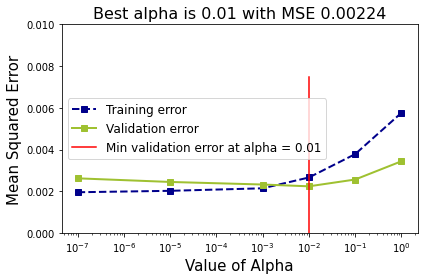

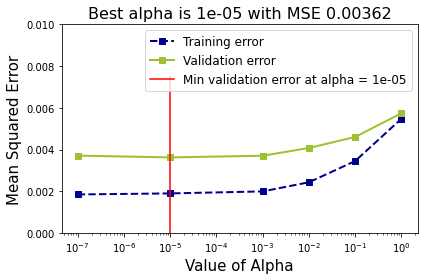

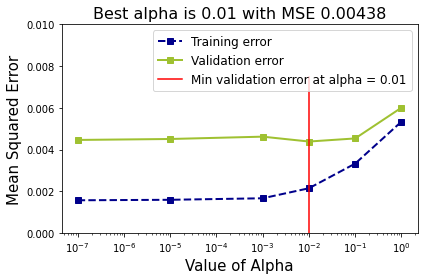

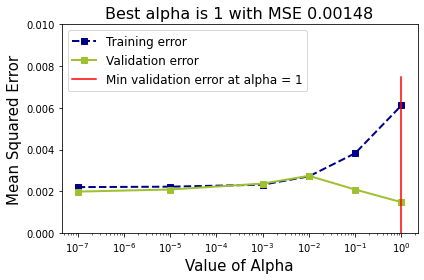

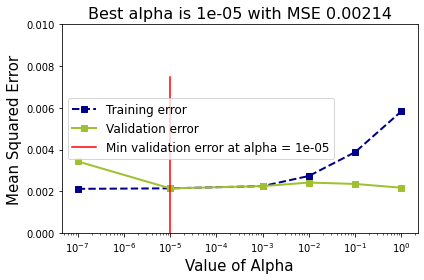

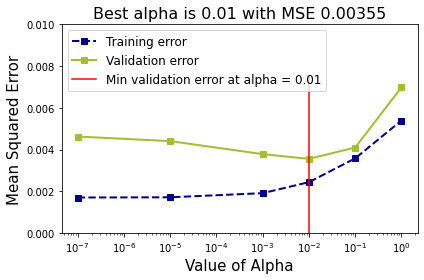

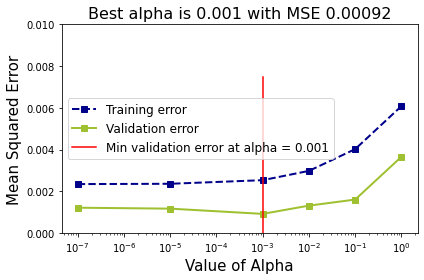

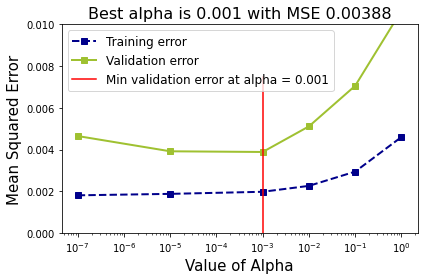

In [19]:
### edTest(test_validation) ###
# Initialise a list to store the best alpha using simple validation for varying random states
best_alpha = []

# Run a loop for different random_states
for i in range(len(ran_state)):

    # Get the train and validation error by calling the function reg_with_validation
    training_error, validation_error = reg_with_validation(ran_state[i])

    # Get the best mse from the validation_error list
    best_mse  = np.min(np.abs(validation_error))
    
    # Get the best alpha value based on the best mse
    best_parameter = alphas[np.argsort(np.abs(validation_error))[0]]
    
    # Append the best alpha to the list
    best_alpha.append(best_parameter)
    
    # Use the helper code given below to plot the graphs
    fig, ax = plt.subplots(figsize = (6,4))
    
    # Plot the training errors for each alpha value
    ax.plot(alphas,training_error,'s--', label = 'Training error',color = 'Darkblue',linewidth=2)
    
    # Plot the validation errors for each alpha value
    ax.plot(alphas,validation_error,'s-', label = 'Validation error',color ='#9FC131FF',linewidth=2 )

    # Draw a vertical line at the best parameter
    ax.axvline(best_parameter, 0, 0.75, color = 'r', label = f'Min validation error at alpha = {best_parameter}')

    ax.set_xlabel('Value of Alpha',fontsize=15)
    ax.set_ylabel('Mean Squared Error',fontsize=15)
    ax.set_ylim([0,0.010])
    ax.legend(loc = 'best',fontsize=12)
    bm = round(best_mse, 5)
    ax.set_title(f'Best alpha is {best_parameter} with MSE {bm}',fontsize=16)
    ax.set_xscale('log')
    plt.tight_layout()
    plt.show()

In [20]:
# Function to perform regularization with cross validation
def reg_with_cross_validation(rs):
    
    # Sample your data to get different splits using the random state
    df_new = df.sample(frac = 1, random_state = rs)
    
    # Assign the values of the 'x' column as the predictor from your sampled dataframe
    x = df_new[['x']].values

    # Assign the values of the 'y' column as the response from your sampled dataframe
    y = df_new['y'].values

    # Create two lists for training and validation error
    training_error, validation_error = [],[]

    # Compute the polynomial features on the entire data
    x_poly = PolynomialFeatures(degree).fit_transform(x.reshape(-1,1))

    # Run a loop for all alpha values
    for alpha in alphas:

        # Initialise a Ridge regression model by specifying the alpha value and with fit_intercept=False
        ridge_reg = Ridge(alpha = alpha, fit_intercept=False)
        
        # Perform cross validation on the modified data with neg_mean_squared_error as the scoring parameter and cv=5
        # Remember to get the train_score
        ridge_cv = cross_validate(ridge_reg, x_poly, y, cv = 5, scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

        # Compute the training and validation errors got after cross validation
        mse_train = np.mean(np.abs(ridge_cv['train_neg_mean_squared_error']))
        mse_val = np.mean(np.abs(ridge_cv['test_neg_mean_squared_error']))
        
        # Append the MSEs to their respective lists 
        training_error.append(mse_train)
        validation_error.append(mse_val)
    
    # Return the train and validation MSE
    return training_error, validation_error

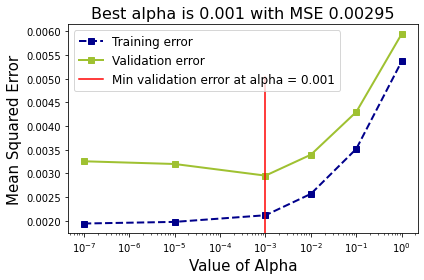

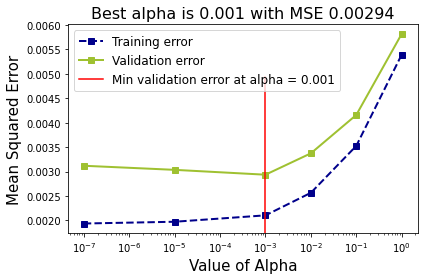

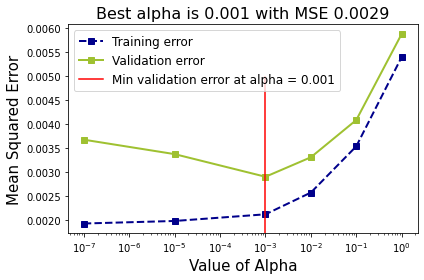

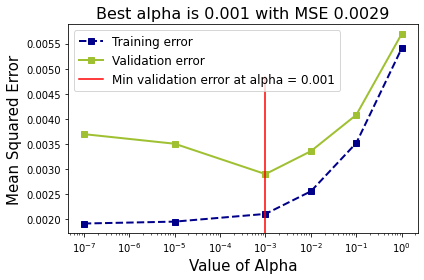

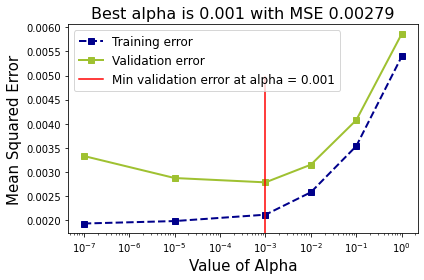

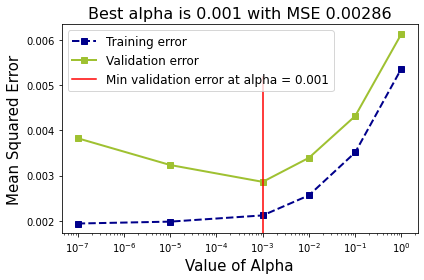

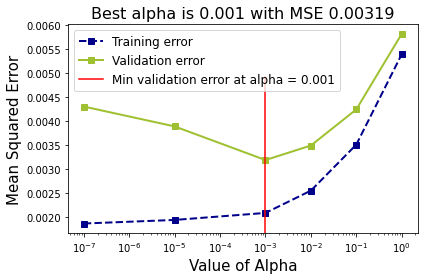

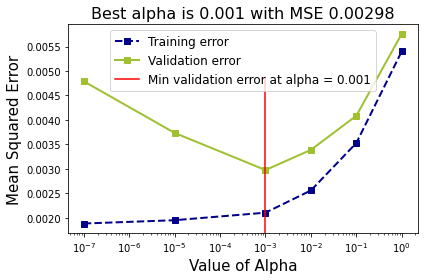

In [21]:
### edTest(test_cross_validation) ###
# Initialise a list to store the best alpha using cross validation for varying random states
best_cv_alpha = []

# Run a loop for different random_states
for i in range(len(ran_state)):
    
    # Get the train and validation error by calling the function reg_with_cross_validation
    training_error, validation_error = reg_with_cross_validation(ran_state[i])
    
    # Get the best mse from the validation_error list
    best_mse  = np.min(validation_error)
    
    # Get the best alpha value based on the best mse
    best_parameter = alphas[np.argsort(validation_error)[0]]
    
    # Append the best alpha to the list
    best_cv_alpha.append(best_parameter)
    
    # Use the helper code given below to plot the graphs
    fig, ax = plt.subplots(figsize = (6,4))
    
    # Plot the training errors for each alpha value
    ax.plot(alphas,training_error,'s--', label = 'Training error',color = 'Darkblue',linewidth=2)
    
    # Plot the validation errors for each alpha value
    ax.plot(alphas,validation_error,'s-', label = 'Validation error',color ='#9FC131FF',linewidth=2 )

    # Draw a vertical line at the best parameter
    ax.axvline(best_parameter, 0, 0.75, color = 'r', label = f'Min validation error at alpha = {best_parameter}')

    ax.set_xlabel('Value of Alpha',fontsize=15)
    ax.set_ylabel('Mean Squared Error',fontsize=15)
    ax.legend(loc = 'best',fontsize=12)
    bm = round(best_mse, 5)
    ax.set_title(f'Best alpha is {best_parameter} with MSE {bm}',fontsize=16)
    ax.set_xscale('log')
    plt.tight_layout()

In [22]:
# Use the helper code below to print your findings
pt = PrettyTable()

pt.field_names = ["Random State", "Best Alpha with Validation", "Best Alpha with Cross-Validation"]

for i in range(6):
    pt.add_row([ran_state[i], best_alpha[i], best_cv_alpha[i]])

print(pt)

+--------------+----------------------------+----------------------------------+
| Random State | Best Alpha with Validation | Best Alpha with Cross-Validation |
+--------------+----------------------------+----------------------------------+
|      0       |            0.01            |              0.001               |
|      10      |           1e-05            |              0.001               |
|      21      |            0.01            |              0.001               |
|      42      |             1              |              0.001               |
|      66      |           1e-05            |              0.001               |
|     109      |            0.01            |              0.001               |
+--------------+----------------------------+----------------------------------+
